In this version, I employ the package NetworkX that allows one to deal efficiently with the boundaries and with correlated hits.

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import numpy as np

In [2]:
class Player:
    
    def __init__(self, name, L, nattack):
        self.L    = L        
        self.name = name
        self.G    = nx.grid_2d_graph(L,L) #create the grid graph 
        
        aux1 = [(i[0],i[1],'cyan',0) for i in self.G.nodes()] 
        aux2 = [(i[0],i[1],0)        for i in self.G.nodes()]         
        self.dfreg  = pd.DataFrame(aux2,columns=['x','y','status']) # register of choices regarding attacks in the opponent
        self.dfmain = pd.DataFrame(aux1,columns=['x','y','ship','status'])
        
        self.n_miss = np.asarray([None] * nattack) 
        self.n_hit  = np.asarray([None] * nattack) 
        self.n_ship = np.asarray([None] * nattack) 
        
        
    def measures(self,i):
        colSeries1 = self.dfreg.iloc[:  ,2] # Select column by index positen using iloc[]
        colSeries2 = self.dfmain.iloc[: ,3] 
            
        self.n_miss[i] = np.sum( np.asarray(colSeries1.values)<0) # for dfregister -1=miss
        self.n_hit[i]  = np.sum( np.asarray(colSeries1.values)>0) # for dfregister  1=hit
        self.n_ship[i] = np.sum( np.asarray(colSeries2.values)>0) # for dfmain >0 indicates ships
        #print('t',i, 'n_miss:',self.n_miss[i], 'n_hit:',self.n_hit[i],'n_ship',self.n_ship[i])


    def initialize_network(self):     
        # https://stackoverflow.com/questions/54969732/ive-an-undirected-networkx-graph-and-want-to-find-all-neighbors-of-node-a-that        
        df     = self.dfmain         
        #---------------------  Lets put ships ---------------------#
        vNewColor = ['red','gray','green','green']
        vNewLship = [4,3,2,2]
        for k in range(len(vNewLship)):
            Lship = vNewLship[k]            
            rdnum = rd.randint(0, self.L-1)# pick at random number for the row or column
            
            flag=0
            count=0
            while(flag==0):
                # pick at random the initial positen to place the ship of size Lship
                iship_min = rd.randint(0,self.L-Lship)
                iship_max = iship_min + Lship

                #put the ship  in row or columns at random
                if rd.random() < 0.5: list_for_ship = [(rdnum, i) for i in range(iship_min,iship_max,1)]
                else:  list_for_ship = [(i, rdnum) for i in range(iship_min,iship_max,1)]

                mybool=[]
                for jj in list_for_ship:
                    dfaux = df.loc[ (df['x']==jj[0]) & (df['y']==jj[1]) ]
                    mybool.append( dfaux['status'].item() )

                if sum( np.array(mybool)==0 ) == Lship: flag=1 
                          
                if count==99: flag=1
                else: count=count+1                            
            
            for jj in list_for_ship:
                df.loc[ (df['x']==jj[0]) & (df['y']==jj[1]), 'ship']   = vNewColor[k]
                df.loc[ (df['x']==jj[0]) & (df['y']==jj[1]), 'status'] = Lship
        
        self.dfmain = df

        
    def attack(self,obj_opp):
        #print( np.asarray(self.dfreg.iloc[: , 2].values), 'SUM', sum( np.asarray(self.dfreg.iloc[: , 2].values)==1 ) )        
        df4 = self.dfreg # just to simplify the later notation

        if sum(self.dfreg['status']==1)>0: # if you have hit any part of a ship
            
            dfaux  = df4.loc[ df4['status']==1 ]
            dfaux2 = dfaux.sample() # Select 1 row randomly
            site  = ( dfaux2['x'].item(),dfaux2['y'].item() )
            
            # Which neighbors have status = 0?  (you haven't chosen previously)
            listneig  = list(self.G.neighbors(site)) 
            listneig2 = [] 
            for jj in listneig: 
                dfaux4 = df4.loc[ (df4['x']==jj[0]) & (df4['y']==jj[1]) ] 
                if dfaux4['status'].item()==0: # If this neighbor has not yet been hit
                    listneig2.append( jj ) 
            
            # Randomly pick a neighbor from listneig2
            if len(listneig2)>0:                 
                rdneig = np.random.choice(range(len(listneig2)))
                rdx, rdy = listneig2[rdneig][0], listneig2[rdneig][1]
            else: # In this case, all the neighbors have been hit
                dfaux   = df4.loc[ df4['status']==0 ]
                dfaux2  = dfaux.sample() # Select one row randomly 
                rdx,rdy = dfaux2['x'].item(), dfaux2['y'].item()                 
        else: 
            dfaux   = df4.loc[ df4['status']==0 ]
            dfaux2  = dfaux.sample() # Select one row randomly
            rdx,rdy = dfaux2['x'].item(), dfaux2['y'].item() 

        dfaux_opp = obj_opp.dfmain.loc[ (obj_opp.dfmain['x']==rdx) & (obj_opp.dfmain['y']==rdy) ] 
        #print( dfaux_opp )
        
        if dfaux_opp['status'].item()==0: 
            #print('you missed')
            self.dfreg.loc[ (self.dfreg['x']==rdx) & (self.dfreg['y']==rdy), 'status'] = -1
        else: #elif dfaux_opp['status'].item()>0:
            #print('you hitted')#,obj_opp.dfmain.loc[ (obj_opp.dfmain['x']==rdx) & (obj_opp.dfmain['y']==rdy) ])
            self.dfreg.loc[ (self.dfreg['x']==rdx) & (self.dfreg['y']==rdy), 'status'] = 1
            obj_opp.dfmain.loc[ (obj_opp.dfmain['x']==rdx) & (obj_opp.dfmain['y']==rdy), 'status'] = -dfaux_opp['status'].item()
            obj_opp.dfmain.loc[ (obj_opp.dfmain['x']==rdx) & (obj_opp.dfmain['y']==rdy), 'ship'] = 'cyan'
            

    def plot_g(self,nattack):
        #https://networkx.github.io/documentation/networkx-1.9/examples/drawing/four_grids.html
        #https://stackoverflow.com/questions/33168699/remove-rotation-effect-when-drawing-a-square-grid-of-mxm-nodes-in-networkx-using
        pos    = dict( (n, n) for n in self.G.nodes() )
        
        colSeries = self.dfmain.iloc[: , 2] #columnSeriesObj
        color     = np.asarray(colSeries.values)

        nx.draw(self.G, with_labels=True, pos=pos, node_color=color, node_size=900)
        plt.axis('off')
        if nattack==0: plt.title("Board of %s at t=0"%(self.name) )
        else:  plt.title("Board of %s after t=%d attacks"%(self.name, nattack) )        
        #plt.title('CYAN: sea     RED: ship of size 4     GRAY: ship of size 3     GREEN: ship of size 2 ')

    def plot_measures(self,nplot):
        
        plt.subplot(1,2,nplot)
        plt.plot( self.n_hit, 's--', label=r'$n_{hit}$'  )
        #plt.plot( self.n_ship,'o-',  label=r'$n_{ship}$' )        
        plt.plot( self.n_miss,'o--', label=r'$n_{miss}$' )
        #plt.ylim(0,len(self.n_miss))
        plt.xlabel( 'Number of attacks' )        
        plt.ylabel( 'Measures' )        
        plt.title(r"Board of %s ended with $n_{ship}=$%d"%(self.name, self.n_ship[-1]) ) 
        plt.legend(fontsize='large')


In [3]:
print('            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 ')

L  = 6
nattack = 25 # number of ships=11

obj1 = Player('Eduardo',L, nattack)
obj2 = Player('Monica' ,L, nattack)

obj1.initialize_network( )
obj2.initialize_network( )

print( obj1.dfmain.sort_values(['x','y']).to_string(index=False) ) #print( df3.to_string(index=False) )

            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 
x  y   ship  status
0  0   cyan       0
0  1   cyan       0
0  2   cyan       0
0  3    red       4
0  4  green       2
0  5   cyan       0
1  0   cyan       0
1  1   cyan       0
1  2   cyan       0
1  3    red       4
1  4  green       2
1  5  green       2
2  0   cyan       0
2  1   cyan       0
2  2   cyan       0
2  3    red       4
2  4   cyan       0
2  5  green       2
3  0   cyan       0
3  1   cyan       0
3  2   cyan       0
3  3    red       4
3  4   cyan       0
3  5   cyan       0
4  0   cyan       0
4  1   cyan       0
4  2   cyan       0
4  3   cyan       0
4  4   cyan       0
4  5   cyan       0
5  0   cyan       0
5  1   cyan       0
5  2   gray       3
5  3   gray       3
5  4   gray       3
5  5   cyan       0


            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 


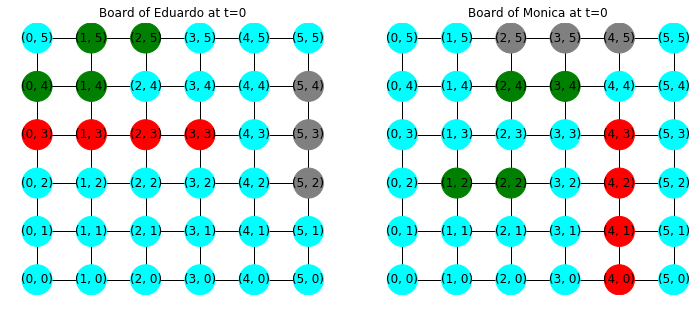

In [4]:
print('            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 ')
plt.figure(figsize=(12,5)) 

plt.subplot(121)
obj1.plot_g(0)

plt.subplot(122)
obj2.plot_g(0)

In [5]:
print(' ---------------------- Battleship: dynamics of alternating attacks --------------------------- ')

# winner: player with more ships at the end of n attacks
for i in range(nattack):
    obj1.measures(i)
    obj2.measures(i)    
    
    obj1.attack(obj2) # player_1 attacks player_2 
    obj2.attack(obj1) # player_2 attacks player_1


 ---------------------- Battleship: dynamics of alternating attacks --------------------------- 


 --------------------------- see the results --------------------------- 


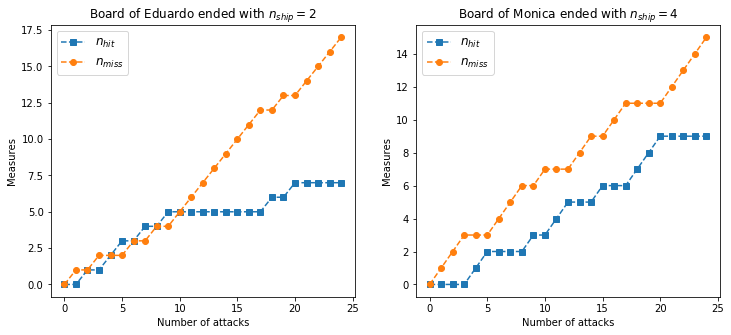

In [6]:
print(' --------------------------- see the results --------------------------- ')
plt.figure(figsize=(12,5)) 
obj1.plot_measures(nplot=1)
obj2.plot_measures(nplot=2)

            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 


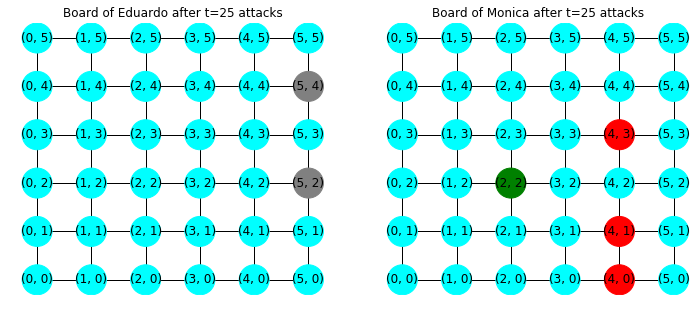

In [7]:
print('            CYAN: sea       RED: ship of size 4       GRAY: ship of size 3       GREEN: ship of size 2 ')
plt.figure(figsize=(12,5)) 
plt.subplot(121)
obj1.plot_g(nattack)
plt.subplot(122)
obj2.plot_g(nattack)